# Load libraries

In [1]:
%load_ext rpy2.ipython

In [27]:
%%R
library(readxl)
library(treemapify)
library(treemap)
library(tidyverse)
library(cowplot)

# Load data

In [3]:
%%R -o best_hits
best_hits <- read_csv("data/Ecoli_pangenome_best_hits.csv")

Rows: 7262 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): qseqid, sseqid, component, cinful_id, pephash, sample, contig, seq
dbl (13): pident, length, mismatch, gapopen, qstart, qend, sstart, send, eva...
lgl  (4): hmmerHit, verified, allStandardAA, signalMatch

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The primary goal here is to get an idea for how many _E. coli_ genome assemblies have microcins. In this regard, we split assemblies into three classes:

1. No microcin
   - nothing that remotely resembled a verified class II (to save the amount of times I type this, I will just refer to them as microcins)
2. verified 
   -  these assemblies had a protein with the exact same sequence as the verified microcin sequences we already know about
3. novel
   - it should be noted that this is pretty loose usage of novel, it really means that the assembly contains something remotely similar to a verified microcin, though it is agnostic of how well the match is or any other components that were identified in the assembly.

What we will do is make a treemap to make three rectangles whose areas correspond to the number of assemblies that belong to each of these three groups. For verified and novel, they also consist of different protein sequences, so they will have sub rectangles whose areas correspond the amount of assemblies that had a given protein sequence.

## Data to be visualized
This contains, the sequence, unique identifier, whether or not it was verified. A somewhat hacky thing I have to do is manually input the amount of assemblies that had no assemblies, because those assemblies don't make it to the final output file.

First, it would be very helpful to know how many assemblies there were total in the analysis.

In [28]:
!wc -l data/Ecoli_samples.txt

    1224 data/Ecoli_samples.txt


In [45]:
%%R
num_samples <- 1224

In [33]:
%%R
best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE) %>%
	count(verified) 

# A tibble: 2 × 2
  verified     n
  <lgl>    <int>
1 FALSE      145
2 TRUE       220


In [57]:
%%R
verified_microcins <- best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE) %>%
	count(verified) %>%
	filter(verified == TRUE) %>%
	select(n) %>%
	as.integer()

In [86]:
%%R

verified_microcin_peptides <- best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE) %>%
	filter(verified == TRUE) %>%
	count(pephash) %>%
	select(n) %>%
	summarise(n_unique_peptides = n()) %>%
	as.integer()


In [58]:
%%R
novel_microcins <- best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE) %>%
	count(verified) %>%
	filter(verified == FALSE) %>%
	select(n) %>%
	as.integer()

In [52]:
%%R
samples_w_microcins <- best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE) %>%
	count(verified) %>%
	summarise(sum = sum(n)) %>%
	as.integer()
samples_w_microcins

[1] 365


In [47]:
%%R
samples_wo_microcins <- num_samples - as.integer(samples_w_microcins)
samples_wo_microcins

[1] 859


In [59]:
%%R
best_hits %>%
	filter(component == "microcins.verified") %>%
	group_by(pephash,verified,sample,seq) %>% summarise(n = n()) %>%
	ungroup() %>%
	mutate(verified = as.factor(verified)) %>%
	add_row(pephash=NA, verified="no_microcin",n=samples_wo_microcins) %>%
	write_csv("data/supplemental/Ecoli_microcin_treemap_data.csv")


`summarise()` has grouped output by 'pephash', 'verified', 'sample'. You can override using the `.groups` argument.


## initial treemap

I set up two treemap figures, one with just the main three classes, and the other with the second subdivision. This isn't something that should be necessary, but it ended up being the only way for me to get the final figure to my liking.

`summarise()` has grouped output by 'pephash', 'verified'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'pephash', 'verified'. You can override using the `.groups` argument.


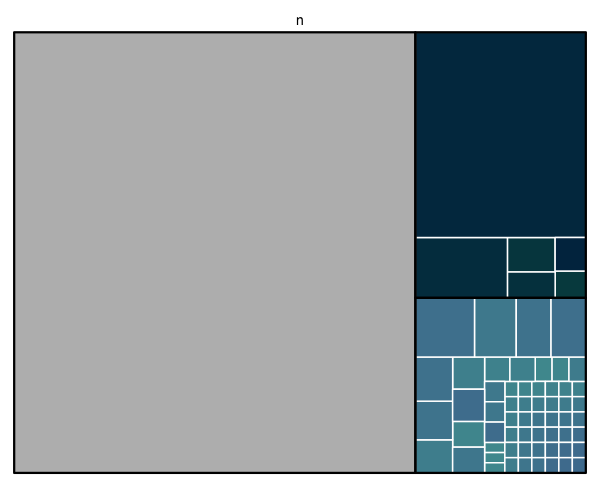

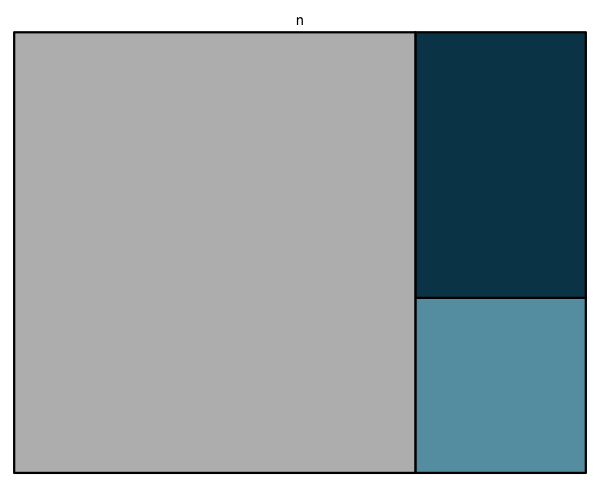

In [60]:
%%R -w 600
best_hits_TM <- best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE) %>%
	group_by(pephash,verified,sample) %>% summarise(n = n()) %>%
	ungroup() %>%
	mutate(verified = as.factor(verified)) %>%
	add_row(pephash=NA, verified="no_microcin",n=samples_wo_microcins) %>% 
	treemap(
		index = c("verified","pephash"),
        vSize = "n",
		border.col=c("black","white"),
    	border.lwds=c(3,2),
		fontsize.labels=c(0,0),
		palette = c("#659eb0","#054457","#BBBBBB")
	)

best_hits_TM_verified <- best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE) %>%
	group_by(pephash,verified,sample) %>% summarise(n = n()) %>%
	ungroup() %>%
	mutate(verified = as.factor(verified)) %>%
	add_row(pephash=NA, verified="no_microcin",n=samples_wo_microcins) %>% 
	treemap(
		index = c("verified"),
        vSize = "n",
		border.col=c("black","white"),
    	border.lwds=c(3,2),
		fontsize.labels=c(0,0),
		palette = c("#659eb0","#054457","#BBBBBB")
	)


The next is less than fun, but just a way of wrangling data so that the final figure looks nice.

In [62]:
%%R
best_hits_TM_data <- best_hits_TM$tm %>%
	mutate(x1 = x0 + w,
         y1 = y0 + h) %>% 
  # get center coordinates for labels
  mutate(x = (x0+x1)/2,
         y = (y0+y1)/2) %>% 
  # mark primary groupings and set boundary thickness
  mutate(primary_group = ifelse(is.na(verified), 2, .5)) %>% 
  # remove colors from primary groupings (since secondary is already colored)
  mutate(color = ifelse(is.na(verified), NA, color))


best_hits_TM_data_verified <- best_hits_TM_verified$tm %>%
	mutate(x1 = x0 + w,
         y1 = y0 + h) %>% 
  # get center coordinates for labels
  mutate(x = (x0+x1)/2,
         y = (y0+y1)/2) %>% 
  # mark primary groupings and set boundary thickness
  mutate(primary_group = ifelse(is.na(verified), 1,1 )) %>% 
  # remove colors from primary groupings (since secondary is already colored)
  mutate(color = ifelse(is.na(verified), NA, color))

best_hits_TM_data <- as.tibble(best_hits_TM_data) %>%
	mutate(color =
		case_when(
			verified == "FALSE" ~ "#659eb0",# "#659eb0",
			verified == "TRUE" ~ "#F4B3A5",#"#C8E3B9",#"#054457",
			verified == "no_microcin" ~ "#BBBBBB"
		)
	)


Now we can plug this into ggplot with our first intermediate plot

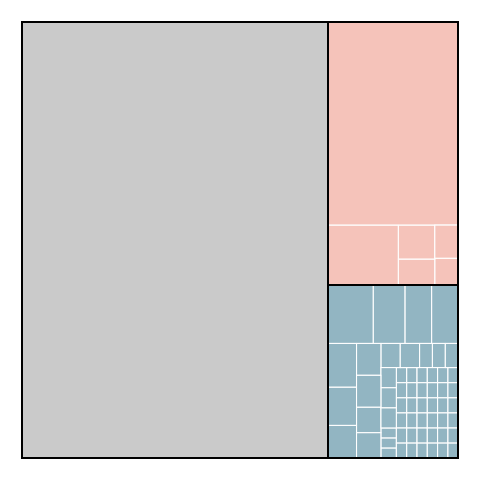

In [63]:
%%R 

p1 <- ggplot(best_hits_TM_data, aes(xmin = x0, ymin = y0, xmax = x1, ymax = y1)) + 
  # add fill and borders for groups and subgroups

  geom_rect(aes(fill = color, size = primary_group),
            show.legend = FALSE, color = "white", alpha = 0.4) +
  scale_fill_identity() +
  # set thicker lines for group borders
  scale_size(range = range(best_hits_TM_data$primary_group)) +
  geom_rect(aes(
                xmin = best_hits_TM_data_verified$x0[1], 
                ymin = best_hits_TM_data_verified$y0[1], 
                xmax = best_hits_TM_data_verified$x1[1], 
                ymax = best_hits_TM_data_verified$y1[1], 
            ),
                fill = NA, color = "black") +
  geom_rect(aes(xmin = best_hits_TM_data_verified$x0[2], 
                ymin = best_hits_TM_data_verified$y0[2], 
                xmax = best_hits_TM_data_verified$x1[2], 
                ymax = best_hits_TM_data_verified$y1[2]
                ),
                 fill = NA, color = "black") +
  geom_rect(aes(xmin = best_hits_TM_data_verified$x0[3], 
                ymin = best_hits_TM_data_verified$y0[3], 
                xmax = best_hits_TM_data_verified$x1[3], 
                ymax = best_hits_TM_data_verified$y1[3]),
                fill = NA, color = "black") +
  
  theme_nothing() 



p1 
# ggsave("best_hits_treemap.png")


Now we just annotate it with numbers that represent the size of the large rectangles and the smaller sub-rectangles. I did this manually, though probably it is better to figure out a way to get these values from the dataset.

Alright, I'm back and definitely need to at least figure out a way to get the other values non-manually. There isn't really a way around manually typing 818, though honestly the only hardcoded value should be total number of assemblies. 

In [68]:
%%R
paste("assemblies:",as.character(samples_wo_microcins))

[1] "assemblies: 859"


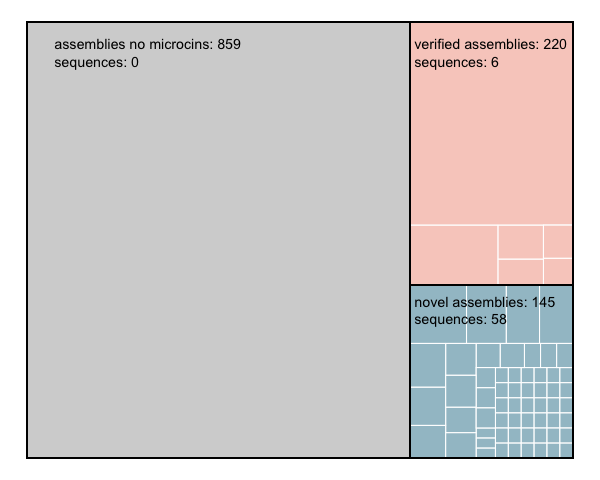

In [98]:
%%R -w 600
microcin_treemap <- p1  + 
	annotate("text",x = 0.05, y = 0.95, 
		label = paste("assemblies no microcins:", as.character(samples_wo_microcins)), 
		size = 5, hjust = 0) +
	annotate("text", x = 0.05,y = 0.91, label = "sequences: 0", size = 5,hjust = 0) +
	annotate("text",x = 0.71, y = 0.95, 
		label =  paste("verified assemblies:", as.character(verified_microcins)), #"verified assemblies: 220", 
		size = 5, hjust = 0) +
	annotate("text",x = 0.71, y = 0.91, 
		label = paste("sequences:", as.character(verified_microcin_peptides)),#"sequences: 6" , 
		size = 5, hjust = 0) +
	annotate("text",x = 0.71, y = 0.32 +0.04, 
		label =  paste("novel assemblies:", as.character(novel_microcins)), #label = "novel assemblies: 186", 
		size = 5, hjust = 0) +
	annotate("text",x = 0.71, y = 0.28 +0.04, 
		label = paste("sequences:", as.character(novel_microcin_peptides)), #"sequences: 95" , 
		size = 5, hjust = 0) #+


microcin_treemap
# ggsave("best_hits_treemap_annotated.svg")

In [99]:
%%R -w 600
microcin_treemap
ggsave("best_hits_treemap_annotated.svg")

R[write to console]: Saving 8.33 x 6.67 in image



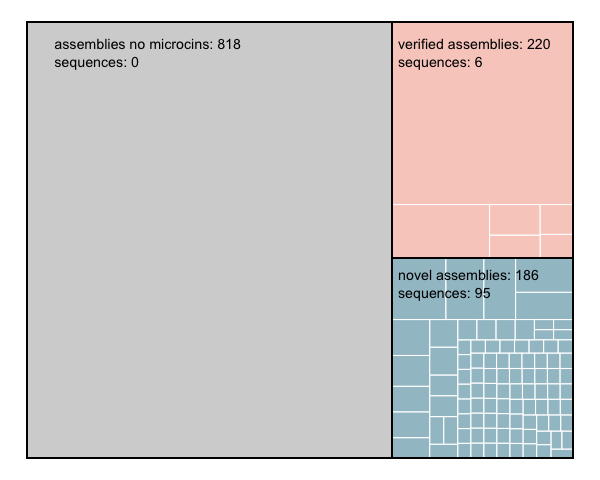

In [22]:
%%R -w 600
microcin_treemap <- p1  + 
	annotate("text",x = 0.05, y = 0.95, label = "assemblies no microcins: 818", size = 5, hjust = 0) +
	annotate("text", x = 0.05,y = 0.91, label = "sequences: 0", size = 5,hjust = 0) +
	annotate("text",x = 0.68, y = 0.95, label = "verified assemblies: 220" , size = 5, hjust = 0) +
	annotate("text",x = 0.68, y = 0.91, label = "sequences: 6" , size = 5, hjust = 0) +
	annotate("text",x = 0.68, y = 0.42, label = "novel assemblies: 186" , size = 5, hjust = 0) +
	annotate("text",x = 0.68, y = 0.38, label = "sequences: 95" , size = 5, hjust = 0) #+


microcin_treemap
# ggsave("best_hits_treemap_annotated.svg")

In [23]:
%%R 
microcin_treemap
ggsave("plots/01_best_hits_treemap_annotated.svg")

R[write to console]: Saving 6.67 x 6.67 in image



# Data for table

So I saved the data needed to make the figure, but that isn't necessarily the best for what I would like to have in the manuscript or for a supplemental. I want the novel peptides, as well as various metrics from BLAST and whatnot

In [22]:
%%R
best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(verified == FALSE) %>%
	filter(hmmerHit == TRUE)

# A tibble: 145 × 25
   qseqid        sseqid pident length mismatch gapopen qstart  qend sstart  send
   <chr>         <chr>   <dbl>  <dbl>    <dbl>   <dbl>  <dbl> <dbl>  <dbl> <dbl>
 1 v1_PLS_987b1… E492_…   80.4     92       18       0      1    92      1    92
 2 v1_PLS_07196… L_tr_…   99.0    102        1       0      1   102      4   105
 3 v1_PLS_718e5… V_sp_…   81.2     16        3       0      1    16      1    16
 4 v1_PLS_e4c44… H47_s…  100       75        0       0     23    97      1    75
 5 v1_PLS_e4c44… H47_s…  100       75        0       0     23    97      1    75
 6 v1_PLS_e4c44… H47_s…  100       75        0       0     23    97      1    75
 7 v1_PLS_e4c44… H47_s…  100       75        0       0     23    97      1    75
 8 v1_PLS_e4c44… H47_s…  100       75        0       0     23    97      1    75
 9 v1_PLS_e4c44… H47_s…  100       75        0       0     23    97      1    75
10 v1_PLS_e4c44… H47_s…  100       75        0       0     23    97      1    75
# … wit

In [20]:
%%R
best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(verified == FALSE) %>%
	filter(hmmerHit == TRUE) %>%
	count(seq, sseqid, pident) %>%
	write_csv("data/supplemental/Ecoli_microcin_novel.csv")